# Computational and Algorithmic Quantification of Neurofeedback Learning
## Part II - Reinforcement Learning 

In [5]:
from numpy import exp
import random
import numpy as np
import pandas as pd
from random import choice
import matplotlib.pyplot as plt

We will run simulations on the Q-learning algorithm that we adjusted for high level NF learning (as explained in the introduction).
This way we can learn about the different parameters that guide learning.

The Q-learning algorithm is as follows:

For every trial:
1. Softmax choice of action: 
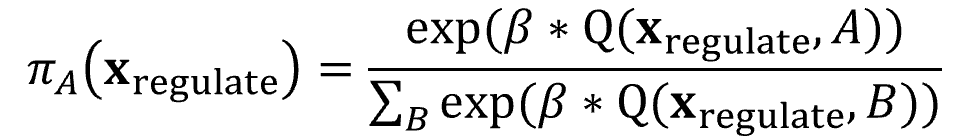

2. Observe reward r(n); compute the reward prediction error (δ):
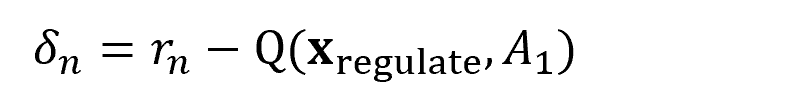

3. Now update the Q value of applied action according to learning rate (α):
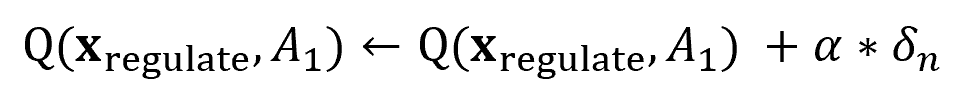



Below are the free parameters of the model (excuding the reward variance that would vary between targets and could potentially be evaluated from NF data). Each of the parameters defines a feature that confines learning. 


In [1]:
N = 100 # number of trials

If the practice is too short, subjects might not get enough experience with each type of strategy to reveal the reward distribution of each action


In [2]:
strategy_vals = [0.6, 0.2, -0.4] # -1 to 1

These values indicate the latent average reward each strategy produces. Here we assume that specific types of strategies have differing effects on regulation success. This of course is an assumption. The analysis applied in the first part of the workshop supported such hypothesis. However, this may not be the case if the neural target is too easy or too hard to regulate (for instance due to low SNR)

In [3]:
alpha = 0.05 # [0-1] learning rate

This parameter controls the speed of learning, by discounting the update of new information into the Q(A) value function.
1 indicates no discounting (the last reward becomes the new Q(A) disregarding previous experience), and 0 does not allow any change.


In [23]:
beta = 5 # [0 - inf] The inverse temperature parameters  

This parameter controls the extent to which subjects focus on maximizing reward locally (for each step), rather than exploring alternative actions with less current utility, or: the exploitation-exploration tradeoff. Low values produce high exploration patterns while high values produce high exploitation patterns. 

First we'll run the algorithm step by step with these parameters

Let's assume the subjects are instructed to choose strategies that relate to one out of three emotion regulation strategies:

In [24]:
# Chosen Strategies
Strategies = ['Reappraisal','Suppression','Watch']
# initial Q values for each strategy based on a random choice pattern 
Q_vals = [0.33,0.33,0.34]    

Q_vals_update = pd.DataFrame(columns = ['Q(A(reappraisal))','Q(A(suppression))','Q(A(watch))'])
A = np.array([],dtype=int)
r = np.array([])

For an example trial N
1. Choose action according to current Q-Values:

In [25]:
# compute choice probabilities per strategy (based on softmax choice rule)
p = exp([i*beta for i in Q_vals])/sum(exp([i*beta for i in Q_vals]))
        
# generate choice according to choice probababilities
A = np.append(A, max(np.where(np.append(-0.00001, np.cumsum(p)) < random.uniform(0, 1))[0]))
print('Q-Values = '+str(Q_vals))
print('Soft Probabilities = '+str(np.round(p,3)))
print('Chosen Action = '+Strategies[A[-1]])

Q-Values = [0.33, 0.33, 0.34]
Soft Probabilities = [0.328 0.328 0.345]
Chosen Action = Watch


2. Generate reward based on choice:

In [26]:
# generate reward distribution based on actual strategy values and some noise
mu, sigma = strategy_vals[A[-1]], 0.2 # mean and standard deviation
s = np.round(np.random.normal(mu, sigma, 100),2)
# choose from distribution 
r = np.append(r, choice(s))
print('Reward = ' + str(r[-1]))

Reward = -0.61


3. Update Q-Values base on reward and learning rate

In [27]:
delta = r[-1] - Q_vals[A[-1]]  # Prediction error
Q_vals[A[-1]] = Q_vals[A[-1]] + alpha * delta # update rule 
Q_vals_update.loc[1] = Q_vals # log data

Q_vals_update

,Q(A(reappraisal)),Q(A(suppression)),Q(A(watch))
1,0.33,0.33,0.2925


Now let's run this 100 times and look at the results:

In [30]:
Q_vals = [0.33,0.33,0.34] 
Q_vals_update = pd.DataFrame(columns = ['Q(A(reappraisal))','Q(A(suppression))','Q(A(watch))'])
A = np.array([],dtype=int)
r = np.array([])
for n in range(1,N):  
    # compute choice probabilities per strategy (based on softmax choice rule)
    p = exp([i*beta for i in Q_vals])/sum(exp([i*beta for i in Q_vals]))
    
    # generate choice according to choice probababilities
    A = np.append(A, max(np.where(np.append(-0.00001, np.cumsum(p)) < random.uniform(0, 1))[0]))

    # generate reward based on choice
    mu, sigma = strategy_vals[A[-1]], 0.2 # mean and standard deviation
    s = np.round(np.random.normal(mu, sigma, 100),2)
    r = np.append(r, choice(s))        
    # update values
    delta = r[-1] - Q_vals[A[-1]]
    Q_vals[A[-1]] = Q_vals[A[-1]] + alpha * delta
    Q_vals_update.loc[n] = Q_vals
        
data = {'strat_choice':A,'reward':r}    
nf_Q_learning_sim = pd.DataFrame(data)

Text(0, 0.5, 'Reward Value')

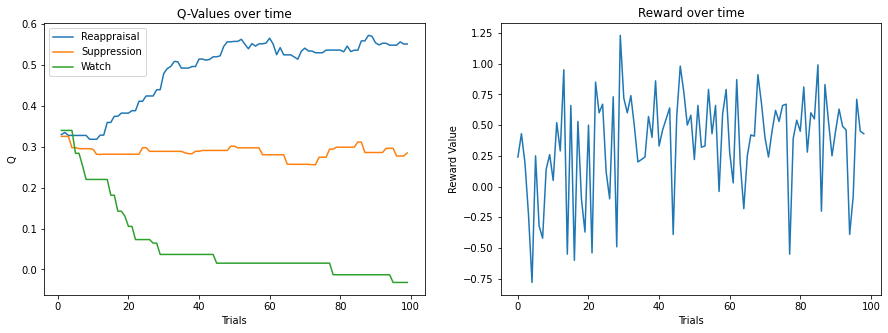

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
# plot the q-values change over trials
ax1.plot(Q_vals_update.iloc[:,0])
ax1.plot(Q_vals_update.iloc[:,1])
ax1.plot(Q_vals_update.iloc[:,2])
ax1.legend(Strategies)
ax1.set_title('Q-Values over time')
ax1.set_xlabel('Trials')
ax1.set_ylabel('Q')
# plot rewards over time
ax2.plot(nf_Q_learning_sim['reward'])
ax2.set_title('Reward over time')
ax2.set_xlabel('Trials')
ax2.set_ylabel('Reward Value')

We can observe that with the parameters, the Q-values converge around their expected values, and the reward is increasing with time.

Next, the entire simulation is wrapped in a function and we can play with the different parameters:

In [32]:
def simulate_nf_Qlearning_vals(N, strat_vals, alpha, beta, plot=1):
# =============================================================================
# This function simulates mental strategies choice and reward data for explicit NF training according to model parameters 
# INPUTS: 
#   - N (int): number of neurofeedback trials (cycles) in practice
#   - strat_vals (list): model parameters of the real value of strategies for target region regulation
#   - alpha (float): learning rate parameter
#   - beta (float): free temperature parameter. Govern the extent of exploration of suboptimal strategies
#
# OUTPUTS: 
#   - nf_Q_learning_sim (N*2 DataFrame): mental strategies choices (A(n)) and rewards r(n) across trials, simulated according to model parameters 
#   - Q_vals_update (N*number of strategies DataFrame): a track of how the Q-learning values change across trials       
# =============================================================================
    from numpy import exp
    import random
    import numpy as np
    import pandas as pd
    from random import choice
    import matplotlib.pyplot as plt
    # initial Q values for each strategy based on a random choice pattern 
    Q_vals = [0.33,0.33,0.34] # an interesting NF feature that we can test here is the effect of biasing subjects initial preference for strategies via task instruction (e.g. "use emotion regulation")
    Q_vals_update = pd.DataFrame(columns = ['Q(A(reappraisal))','Q(A(suppression))','Q(A(watch))'])
    A = np.array([],dtype=int)
    r = np.array([])
    for n in range(1,N):
        
        # compute choice probabilities per strategy (based on softmax choice rule)
        p = exp([i*beta for i in Q_vals])/sum(exp([i*beta for i in Q_vals]))
        
        # generate choice according to choice probababilities
        A = np.append(A, max(np.where(np.append(-0.00001, np.cumsum(p)) < random.uniform(0, 1))[0]))

        # generate reward based on choice
        mu, sigma = strat_vals[A[-1]], 0.2 # mean and standard deviation
        s = np.round(np.random.normal(mu, sigma, 100),2)
        # implement this part with choices(rewards,weights) but generate weights accordingly...
        r = np.append(r, choice(s))        
        # update values
        delta = r[-1] - Q_vals[A[-1]]
        Q_vals[A[-1]] = Q_vals[A[-1]] + alpha * delta
        Q_vals_update.loc[n] = Q_vals
        
    data = {'strat_choice':A,'reward':r}    
    nf_Q_learning_sim = pd.DataFrame(data)


    if plot:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
        # plot the q-values change over trials
        ax1.plot(Q_vals_update.iloc[:,0])
        ax1.plot(Q_vals_update.iloc[:,1])
        ax1.plot(Q_vals_update.iloc[:,2])
        ax1.legend(Strategies)
        ax1.set_title('Q-Values over time')
        ax1.set_xlabel('Trials')
        ax1.set_ylabel('Q')
        # plot rewards over time
        ax2.plot(nf_Q_learning_sim['reward'])
        ax2.set_title('Reward over time')
        ax2.set_xlabel('Trials')
        ax2.set_ylabel('Reward Value')


    return [nf_Q_learning_sim, Q_vals_update] 

########################

Choose different values for the each parameter and see if learning converges. 

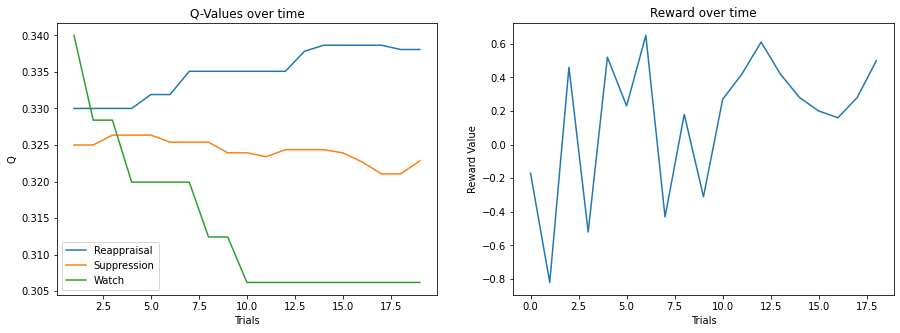

In [36]:

Trials = 20
strat_vals = [0.6,0.2,-0.4]
alpha = 0.01
beta = 5

sim, qvals = simulate_nf_Qlearning_vals(N=Trials, strat_vals=strat_vals,alpha=alpha,beta=beta,plot=1)